In [1]:
import pandas as pd 
import numpy as np 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

#grafting/ acrage table
graft_df = pd.read_csv("graft.csv")

#production table
prod_df = pd.read_csv("production.csv")

#merge graft and production datasets 
df = prod_df.merge(graft_df)

#Make prod_wk datetime
df['prod_wk'] = pd.to_datetime(df['prod_wk'])

#Remove unneeded columns 
df = df.drop(['prod_date_cnt', 'prod_wk_no', 'min_date','max_date' ], axis=1)

#data cleaning
boxes = df['var_boxes']
acres = df['acres']

one_hot = pd.get_dummies(df['variety_desc'])

# Concatenate the one-hot encoded column with the original dataframe
df = pd.concat([df, one_hot], axis=1)

#create a new column for production yield (boxes per acre)
df['yield'] = boxes/acres 

#create a new column for age of the variety 
prod_yr = df['prod_yr'] 
graft_year = df['year_planted_grafted'] 
df['age'] = prod_yr - graft_year

#create a new column for yield classification: 
# High(2) : yield > 170  | Medium(1) : 170 > yield > 55   | Low(0) : yield < 55 
df['yield_class'] = df['yield'].apply(lambda x: 'high' if x > 175 else ('medium' if x >= 55  else 'low'))

num_high_yield = (df['yield_class'] == 'high').sum()
print(f"There are {num_high_yield} high yield values.")

num_med_yield = (df['yield_class'] == 'medium').sum()
print(f"There are {num_med_yield} medium yield values.")

num_low_yield = (df['yield_class'] == 'low').sum()
print(f"There are {num_low_yield} low yield values.")

There are 1232 high yield values.
There are 1660 medium yield values.
There are 1379 low yield values.


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
#rename
df = df.rename(columns={'prod_wk': 'date'})
df['color_code'] = pd.factorize(df['color'])[0]
df.head()
print(df['color'].unique())
print(df['color_code'].unique())
#GREEN  = 0 
#RED = 1
#BLACK = 2 
#NAN = -1
one_hot = pd.get_dummies(df['color'], prefix='color')
df = pd.concat([df, one_hot], axis=1)

one_hot2 = pd.get_dummies(df['ranch_no'], prefix = 'ranch')
df = pd.concat([df, one_hot2], axis=1)


df = df.rename(columns={'date': 'Date'})

#import weather and precipitation dataset
temps_df = pd.read_csv("temps.csv")

#drop unneeded columns 
temps_df = temps_df.drop(['Unnamed: 4', 'Unnamed: 5'], axis=1)

# convert the 'Date' column to datetime format
temps_df['Date'] = pd.to_datetime(temps_df['Date'])

# set the 'Date' column as the index
temps_df.set_index('Date', inplace=True)

# resample the data by week and calculate the mean of 'Daily_High'
weekly_avg = temps_df['Daily_High'].resample('W').mean()

#Make weekly_avg into a dataframe
weekly_avg = pd.DataFrame(weekly_avg)

#Add weekly_low_avg to weekly_avg
weekly_avg['weekly_low_avg'] =  temps_df['Daily _Low'].resample('W').mean()
#Add weekly_precipitation_avg to weekly_avg
weekly_avg['weekly_precipitation_avg'] =  temps_df['Precipitation '].resample('W').mean()
#Rename 'Daily_High' to 'weekly_high_avg'
weekly_avg = weekly_avg.rename(columns={'Daily_High': 'weekly_high_avg'})

temps_df.reset_index(inplace=True) 
temps_df.head()

merged_df = pd.merge(df, temps_df, on = 'Date', how='inner')
merged_df

['GREEN' 'RED' 'BLACK' nan]
[ 0  1  2 -1]


,Date,ranch_no,ranch_sub,var_cd,variety_desc,var_boxes,color,prod_yr,grafted,acres,...,ranch_32,ranch_33,ranch_34,ranch_35,ranch_36,ranch_37,ranch_50,Daily_High,Daily _Low,Precipitation
0,2015-07-13,1,NaN,178,ARRA 15 - SWEETIES,3905,GREEN,2015,True,36.00,...,0,0,0,0,0,0,0,94,68,0.0
1,2015-07-13,14,NaN,16,ARRA 16,3038,GREEN,2015,True,8.00,...,0,0,0,0,0,0,0,94,68,0.0
2,2015-07-13,14,NaN,16,ARRA 16,3038,GREEN,2015,True,10.00,...,0,0,0,0,0,0,0,94,68,0.0
3,2015-07-13,29,SW,71,SUGRAONE,6389,GREEN,2015,True,18.00,...,0,0,0,0,0,0,0,94,68,0.0
4,2015-07-13,29,NW,71,SUGRAONE,23119,GREEN,2015,True,70.00,...,0,0,0,0,0,0,0,94,68,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4262,2018-11-12,32,NE,96,AUTUMN KING,23204,GREEN,2018,False,282.80,...,1,0,0,0,0,0,0,74,39,0.0
4263,2018-11-12,32,NW,755,ARRA 28 - ARRA PASSION PUNCH,667,RED,2018,True,69.35,...,1,0,0,0,0,0,0,74,39,0.0
4264,2019-07-01,33,W,90,EARLY SWEET,4155,GREEN,2019,False,63.00,...,0,1,0,0,0,0,0,93,65,0.0
4265,2019-07-01,33,W,90,EARLY SWEET,4155,GREEN,2019,True,35.00,...,0,1,0,0,0,0,0,93,65,0.0


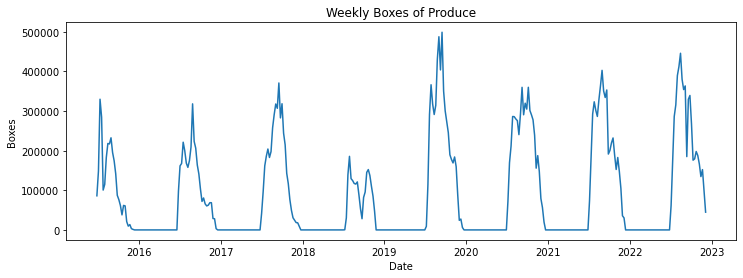

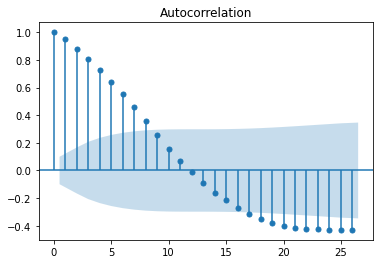

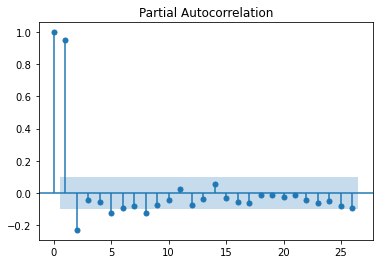

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None


                               SARIMAX Results                                
Dep. Variable:              var_boxes   No. Observations:                  389
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4646.217
Date:                Wed, 08 Mar 2023   AIC                           9298.433
Time:                        21:10:02   BIC                           9310.316
Sample:                    06-28-2015   HQIC                          9303.145
                         - 12-04-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3713      0.116      3.207      0.001       0.144       0.598
ma.L1         -0.1780      0.119     -1.500      0.134      -0.410       0.055
sigma2      1.301e+09   3.79e-11   3.44e+19      0.0

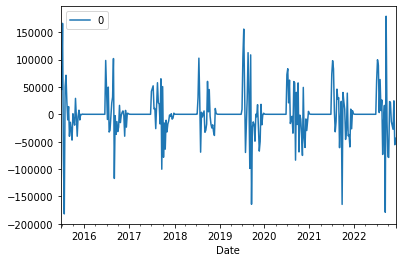

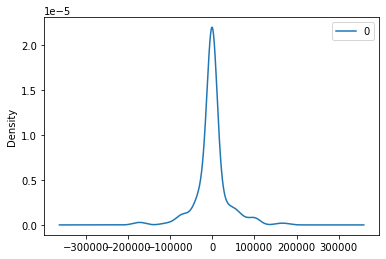

Test RMSE: 49724.591


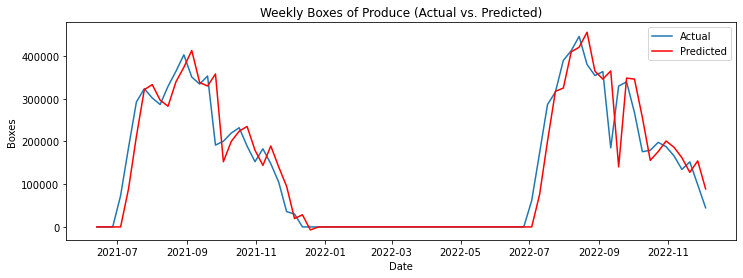

In [3]:
# Resample the data by week and sum the 'boxes' column
merged_df.set_index('Date', inplace=True)
weekly_data = merged_df['var_boxes'].resample('W').sum()

# Plot the time series data
plt.figure(figsize=(12, 4))
plt.plot(weekly_data)
plt.title('Weekly Boxes of Produce')
plt.xlabel('Date')
plt.ylabel('Boxes')
plt.show()

# Check the autocorrelation and partial autocorrelation plots
plot_acf(weekly_data)
plt.show()

plot_pacf(weekly_data)
plt.show()

# Fit an ARIMA model
model = ARIMA(weekly_data, order=(1, 1, 1))
model_fit = model.fit()

# Print the summary of the model
print(model_fit.summary())

# Plot the residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# Plot the density plot of the residuals
residuals.plot(kind='kde')
plt.show()

# Evaluate the model by calculating the Root Mean Squared Error (RMSE)
train_size = int(len(weekly_data) * 0.8)
train_data, test_data = weekly_data[0:train_size], weekly_data[train_size:]

history = [x for x in train_data]
predictions = []

for i in range(len(test_data)):
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_data[i]
    history.append(obs)

error = mean_squared_error(test_data, predictions, squared=False)
print('Test RMSE: %.3f' % error)

# Plot the predicted values against the test data
plt.figure(figsize=(12, 4))
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(test_data.index, predictions, color='red', label='Predicted')
plt.legend()
plt.title('Weekly Boxes of Produce (Actual vs. Predicted)')
plt.xlabel('Date')
plt.ylabel('Boxes')
plt.show()




/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None


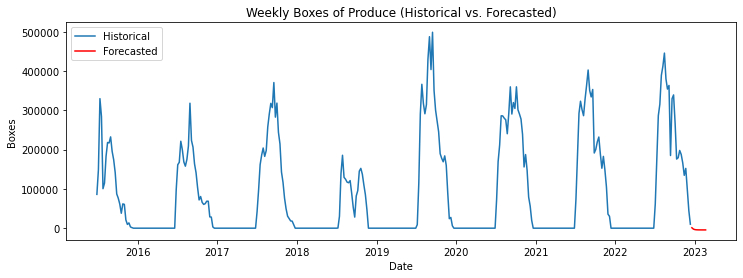

In [22]:
# Fit an ARIMA model to the resampled data
historical_data = df[df['Date'] <= '2023-12-31']
historical_data.set_index('Date', inplace=True)
weekly_data = historical_data['var_boxes'].resample('W').sum()

model = ARIMA(weekly_data, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the values for 2024
forecast_data = model_fit.forecast(steps=10)
                                   
# Plot the forecasted values along with the historical data
plt.figure(figsize=(12, 4))
plt.plot(weekly_data.index, weekly_data.values, label='Historical')
plt.plot(forecast_data.index, forecast_data.values, color='red', label='Forecasted')
plt.legend()
plt.title('Weekly Boxes of Produce (Historical vs. Forecasted)')
plt.xlabel('Date')
plt.ylabel('Boxes')
plt.show()